In [33]:
%load_ext autoreload
%autoreload 2

# Zugriff auf die Funktionen in utils.py
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# import der notwendigen Funktionen für Data Loading
from algorithms.utils import read_file
from algorithms.utils import order_block_labels

In [67]:
# Definieren des Dateipfads und des Event-Typs
file_name = 'data/Events_Match_Test_TEAM_A_vs_TEAM_B.csv'
event_type = 'Shifts'

# Laden der Daten mit der read_file Funktion aus utils.py
df = read_file(file_name, event_type)

df.head()

,Timestamp (ms),Timestamp in local format,Player ID,Name,Event type,Duration (s),Distance,Distance (speed | Very low),Distance (speed | Low),Distance (speed | Medium),Distance (speed | High),Distance (speed | Very high),Distance (speed | Sprint),Distance (speed | 0 - 0 km/h),Metabolic Power (Ø),Speed (max.),Skating Load,Skating Intensity
0,1670697995000,12/10/2022;07:46:35.000 PM,438,D TEST,Shift,34.707001,114.0,29.0,15,25,36,9,0.0,NaN,321.93,22.60,21.67,37.45
1,1670697995000,12/10/2022;07:46:35.000 PM,443,D TEST,Shift,43.952999,177.0,25.0,21,39,51,36,4.0,NaN,382.01,24.34,28.74,39.24
4,1670697995000,12/10/2022;07:46:35.000 PM,470,D3 Guest,Shift,82.765999,288.0,45.0,83,70,87,3,0.0,NaN,331.98,21.88,51.74,37.51
7,1670697995000,12/10/2022;07:46:35.000 PM,471,D4 Guest,Shift,57.615002,215.0,34.0,29,59,79,14,0.0,NaN,360.89,21.75,46.27,48.18
11,1670697995000,12/10/2022;07:46:35.000 PM,448,FW TEST,Shift,20.010000,1.0,1.0,0,0,0,0,0.0,NaN,9.38,4.64,0.49,1.47


Adjustment add_sis_column()

In [70]:
#prerequisites
from algorithms.utils import find_optimal_amount_of_shifts

find_optimal_amount_of_shifts(df, True, False)
df["Player ID"].dtype

dtype('int64')

In [71]:
from sklearn.cluster import KMeans

In [72]:
df["Player ID"].dtype

dtype('int64')

In [86]:
from algorithms.utils import generate_block_config

block_config = generate_block_config(
    naive=True,  # or False, depending on the analysis
    verbose=False,
    team_name="Guest",
    file_name_raw_data=file_name,
    file_name_save_plot=None  # Optional
)

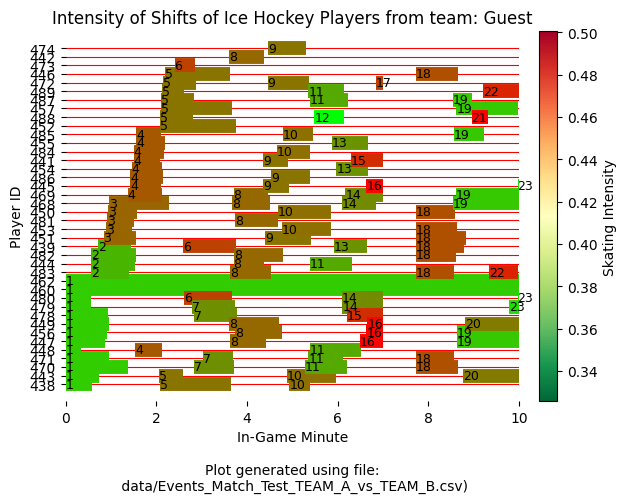

,timestamp,time,Timestamp (ms),Duration (s),Player ID,Skating Intensity,Shift_Label,block_intensity,Time Since Start
0,2022-12-10 18:46:35,0 days 00:00:34.707001,1670697995000,34.707001,438,37.45,1,0.359446,0.000000
1,2022-12-10 18:46:35,0 days 00:00:43.952999,1670697995000,43.952999,443,39.24,1,0.359446,0.000000
4,2022-12-10 18:46:35,0 days 00:01:22.765999,1670697995000,82.765999,470,37.51,1,0.359446,0.000000
7,2022-12-10 18:46:35,0 days 00:00:57.615002,1670697995000,57.615002,471,48.18,1,0.359446,0.000000
11,2022-12-10 18:46:35,0 days 00:00:20.010000,1670697995000,20.010000,448,1.47,1,0.359446,0.000000
...,...,...,...,...,...,...,...,...,...
2212,2022-12-10 18:55:47,0 days 00:00:47.403000,1670698547000,47.403000,489,50.58,22,0.475900,9.200000
2252,2022-12-10 18:55:55,0 days 00:00:38.848000,1670698555000,38.848000,483,44.60,22,0.475900,9.333333
2330,2022-12-10 18:56:22,0 days 00:00:34.327999,1670698582000,34.327999,479,39.51,23,0.346567,9.783333
2371,2022-12-10 18:56:33,0 days 00:00:24.080999,1670698593000,24.080999,445,40.65,23,0.346567,9.966667


In [101]:
from algorithms.utils import plot_shifts_with_intensity

plot_shifts_with_intensity(df, 
    block_config,
    time_window_start=0,  # Start time in playing minutes
    time_window_duration=10,  # Duration of the window to be visualized in minutes
    intensity_indicator="Skating Intensity"  # The exact column in your df
)

In [96]:
def add_sis_column(df, players):
    """
    Adds a 'SIS' (Shift Intensity Score) column to the DataFrame for guest players excluding goalkeepers.
    This function filters the DataFrame for guest players, calculates the optimal number of shifts using KMeans clustering,
    computes the average shift intensity, and calculates the SIS for each player based on the average intensity
    of all their shifts relative to the overall average shift intensity of all players.

    Parameters:
    - df: pandas.DataFrame containing player data including columns for 'Name', 'Timestamp (ms)', 'Duration (s)', and 'Skating Intensity'.
    - player: list of strings containing the Player ID of the selected players to calculate SIS for.

    Returns:
    - pandas.DataFrame: The original DataFrame with an added 'SIS' column for each player.
    """
    # Filter DataFrame for parameter players
    df_filtered = df[df['Player ID'].isin(players)].copy()

    # Finding the optimal number of shifts
    optimal_shifts, shift_labels = find_optimal_amount_of_shifts(df_filtered, True, False)

    # Preparing data for clustering
    data_for_clustering = df_filtered[["Timestamp (ms)", "Duration (s)"]]

    # Clustering with KMeans
    kmeans = KMeans(n_clusters=optimal_shifts)
    kmeans.fit(data_for_clustering)

    # Adding cluster labels
    df_filtered["Shift_Label"] = kmeans.labels_

    # Calculating average intensity for each shift
    df_filtered['Average_Shift_Intensity'] = df_filtered.groupby('Shift_Label')['Skating Intensity'].transform('mean')

    # Average intensity of all shifts for each player
    player_shift_means = df_filtered.groupby(['Name', 'Shift_Label'])['Skating Intensity'].mean().reset_index()
    player_average_intensity = player_shift_means.groupby('Name')['Skating Intensity'].mean()

    # Average value of intensities for all shifts of all players
    overall_average_shift_intensity = player_shift_means['Skating Intensity'].mean()

    # Calculating SIS for each player
    player_sis = player_average_intensity / overall_average_shift_intensity

    # Adding the SIS to df_filtered
    df_filtered['SIS'] = df_filtered['Name'].map(player_sis)

    # order the shifts
    df_filtered = order_block_labels(df_filtered)

    return df_filtered


In [74]:
# list of strings containing the Player ID of the selected players for Team "TEST"
#players = ["438", "443", "448", "447", "456", "449", "460", "444", "439", "451", "453", "450", "445", "454", "441", "455", "452", "457", "446", "442"]

player = [438, 443, 448, 447, 456, 449, 460, 444, 439, 451, 453, 450, 445, 454, 441, 455, 452, 457, 446, 442]

In [99]:
df_sis = add_sis_column(df, player)

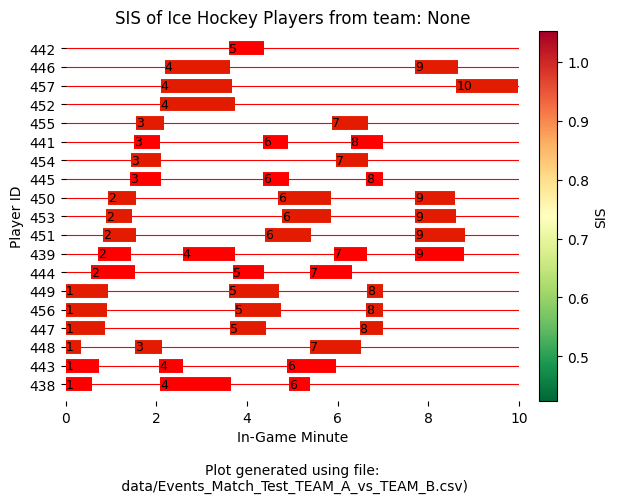

In [100]:
plot_SIS(df_sis,   
        starting_minute=0,
        time_window=10,
        team_name="None",
        file_name_raw_data=file_name)